In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 #deal with images
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
np.random.seed(42)

training = pd.read_csv('training_set.csv')
meta_training = pd.read_csv('training_set_metadata.csv')
merged = training.merge(meta_training, on = "object_id")

In [3]:
import seaborn as sns

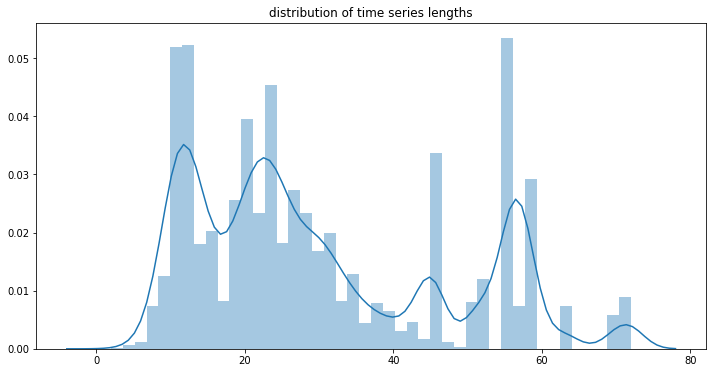

In [4]:
#Plot displaying the distribution of the length of the time series available in the data set.

ts_lens = training.groupby(['object_id', 'passband']).size()
f, ax = plt.subplots(figsize=(12, 6))
sns.distplot(ts_lens, ax=ax)
ax.set_title('distribution of time series lengths')
plt.show()

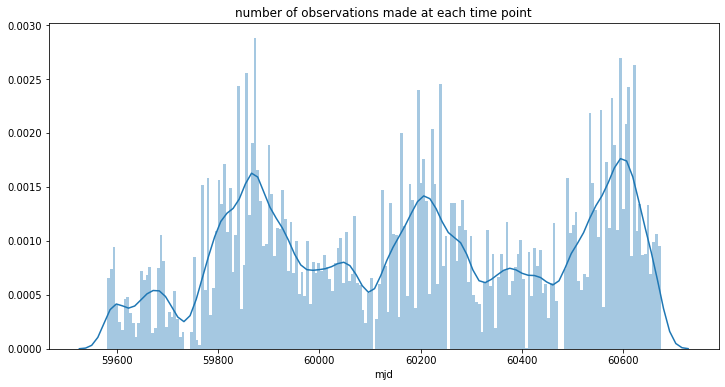

In [5]:
#No of observation made at a time is also not unifrom.
#The no of observation is uneven throughout the sampling period


f, ax = plt.subplots(figsize=(12, 6))
sns.distplot(training['mjd'], ax=ax, bins=200)
ax.set_title('number of observations made at each time point')
plt.show()

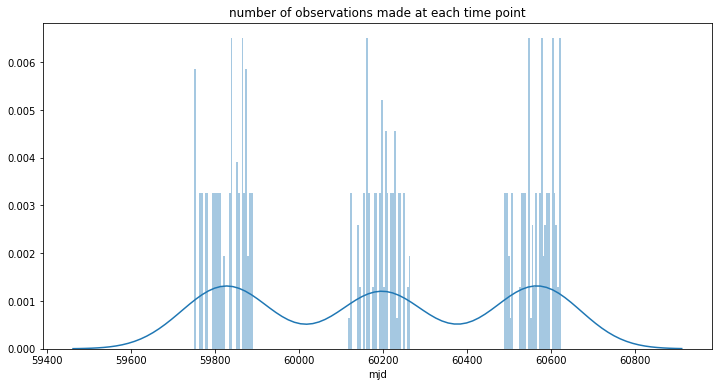

In [6]:
#This plot shows the no of obseravtion made for an specific object
#This is also non-uniform throughout the sampling period

f, ax = plt.subplots(figsize=(12, 6))
sns.distplot(training[training['object_id'] == 615]['mjd'], ax=ax, bins=200)
ax.set_title('number of observations made at each time point')
plt.show()

In [7]:
#DATA PREPROCESSING
#HELPER FUNCTION

#This is implementation for the sigmoid helper function
def sigmoid(x):
    return 1/(1 + np.exp(-x))

#This function takes a time series and coverts it into 2-D numpy array which is like an image.
def create_r_matrix(signal):
    r = np.zeros((signal.shape[0], signal.shape[0]))
    for i in range(r.shape[0]):
        for j in range(r.shape[1]):
            r[i][j] = sigmoid(abs(signal[i] - signal[j]))
    return r

In [8]:
#The following function takes in merged_dataset and create a dictionary of recurrent matrix for the time series vectors for each object in each passband
def create_object_dict(merged):
    objects = {} #Empty dictionary which stores objects by using using their object_ids as keys
    #Interator for each unique object id available i nthe dataset
    for obj in tqdm(np.unique(merged['object_id'])):
        #Vector for the containing the recurrent matrix for each passband
        passband = []
        #iterate over each passband for the specific object, create and store the recurrent matrix in the passbands array
        for passbands in np.unique(merged.passband):
            #create an array of the time series value of the passband for the object with object id obj
            flux_value = merged[(merged.object_id == obj) & (merged.passband == passbands)].flux.values
            #now create the 2-D recurrent matrix and append them to the passband array
            passband.append(create_r_matrix(flux_value))
        objects[obj] = (np.asarray(passband), max(merged[merged.object_id == obj].target))
    return objects
            
            

In [16]:
#the following function helps us calculate the min and max length of the matrices, among the different passbands for an object.

def get_min_max_length(r_passband):
    #We get the passband vector for an object as an argument. This vector contains recurrent matrices for different passbands
    #initialize the min_len and lax_len variable
    min_len, max_len = 0, 0
    #iterate through all the passbands 
    for passband in np.unique(merged['passband']):
        if passband == 0:
            length = len(r_passband[passband])
            min_len = length
            max_len = length
        else:
            length = len(r_passband[passband])
            min_len = min(length, min_len)
            max_len = max(length, max_len)
    return min_len, max_len

In [19]:
#the following function helps us to crop the passband matrices according to the smallest of them
def crop_matrices(objects):
    #iterate through each entry in the objects dictionary
    for obj in tqdm(objects.keys()):
        min_len, max_len = get_min_max_length(objects[obj][0])
        #iterate through each matrix 
        for passband in np.unique(merged.passband):
            objects[obj][0][passband] = objects[obj][0][passband][:min_len, :min_len]
    return objects

In [11]:
objects = create_object_dict(merged)

100%|██████████████████████████████████████████████████████████████████████████████| 7848/7848 [16:10<00:00,  8.09it/s]


In [20]:
crop_object = crop_matrices(objects)

100%|██████████████████████████████████████████████████████████████████████████████| 7848/7848 [09:30<00:00, 13.74it/s]


(57, 57)


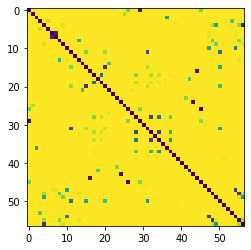

In [21]:
print(crop_object[615][0][0].shape)
plt.imshow(crop_object[615][0][0])

100%|██████████████████████████████████████████████████████████████████████████| 7848/7848 [00:00<00:00, 827702.43it/s]


Counter({57: 546,
         56: 435,
         51: 298,
         55: 365,
         30: 470,
         40: 1,
         31: 1,
         14: 175,
         10: 1270,
         12: 1032,
         11: 1398,
         7: 110,
         13: 464,
         8: 342,
         9: 786,
         6: 68,
         16: 6,
         5: 25,
         3: 9,
         15: 35,
         4: 11,
         2: 1})

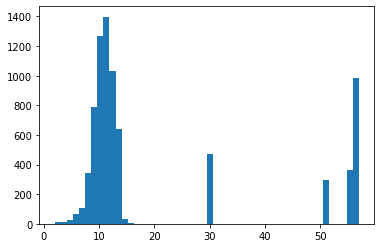

In [22]:
#We will look at the distribution of the shapes in the processed dataset
from collections import Counter

#shapes matrix will have info about the all the shpaes in the processed dataset
shapes = []
for key in tqdm(crop_object.keys()):
    shapes.append(crop_object[key][0][0].shape[0])
plt.hist(shapes, bins=50)
Counter(shapes)

In [29]:
import math

#we are now going to use only the images with dimension greater that 50 as CNN will work on them primarily
#creating a copy of the cropped data set
crop2 = np.copy(crop_object).item()

#for all the objects present in the crop_object object
for key in tqdm(crop2.keys()):
    #obtain the shape of the object
    shape = crop2[key][0][0].shape[0]
    if shape < 11:
        for passband in np.unique(merged.passband):
            #how much we will increase the border
            increaseBorder = abs(shape-11)/2
            #this much amount will increase
            crop2[key][0][passband] = cv2.copyMakeBorder(src = crop2[key][0][passband],
                                                             top = math.ceil(increaseBorder), 
                                                             left = math.ceil(increaseBorder),
                                                             bottom = round(increaseBorder),
                                                             right = round(increaseBorder),
                                                             borderType = cv2.BORDER_REFLECT)
    elif shape>11 and shape < 25:
        for passband in np.unique(merged.passband):
            crop2[key][0][passband] = crop2[key][0][passband][:-(shape-11), :-(shape-11)]
            
    
    elif shape >= 50 and shape < 57:
        for passband in np.unique(merged.passband):
            increaseBorder57 = abs(shape-57)/2
            crop2[key][0][passband] = cv2.copyMakeBorder(src = crop2[key][0][passband],
                                                             top = math.ceil(increaseBorder57), 
                                                             left = math.ceil(increaseBorder57),
                                                             bottom = round(increaseBorder57),
                                                             right = round(increaseBorder57),
                                                             borderType = cv2.BORDER_REFLECT)
    else:
        continue

100%|██████████████████████████████████████████████████████████████████████████████| 7848/7848 [02:47<00:00, 46.93it/s]


In [30]:
objects = list(crop2.keys())
input_images = list()
labels = list()
for key in tqdm(objects):
    if crop2[key][0][0].shape[0] == 57:
        img = np.stack((crop2[key][0][0],
                        crop2[key][0][1],
                        crop2[key][0][2],
                        crop2[key][0][3],
                        crop2[key][0][4]), axis = -1)  
                                           
        input_images.append(np.expand_dims(img, axis = 0))
        labels.append(crop2[key][1])                                                        
input_images = np.vstack(input_images)     
input_images.shape

100%|███████████████████████████████████████████████████████████████████████████| 7848/7848 [00:00<00:00, 53518.62it/s]


(1644, 57, 57, 5)

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils


train_fraction = 0.8
#Contructing the labels required for the classification tasks
encoder = LabelBinarizer()
y = encoder.fit_transform(labels)
x = input_images

#the test, train split

train_tensors, test_tensors, train_targets, test_targets =\
    train_test_split(x, y, train_size = train_fraction, random_state = 42)

val_size = int(0.5*len(test_tensors))

val_tensors = test_tensors[:val_size]
val_targets = test_targets[:val_size]
test_tensors = test_tensors[val_size:]
test_targets = test_targets[val_size:]

In [33]:
#Attempt 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = (None, None,5)))
model.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 2)) 

model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 2)) 

model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(GlobalMaxPooling2D()) 

model.add(Dense(256, activation = 'linear'))
model.add(Dense(128, activation = 'linear'))
model.add(Dense(14, activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 100
model.fit(train_tensors, train_targets, 
          validation_data=(val_tensors, val_targets),
          epochs=epochs, batch_size=80, verbose=1)

Epoch 1/100
17/17 [==============================] - 2s 94ms/step - loss: 2.0581 - accuracy: 0.3924 - val_loss: 1.9567 - val_accuracy: 0.4634
Epoch 2/100
17/17 [==============================] - 1s 51ms/step - loss: 1.8666 - accuracy: 0.4099 - val_loss: 1.8938 - val_accuracy: 0.4634
Epoch 3/100
17/17 [==============================] - 1s 51ms/step - loss: 1.8320 - accuracy: 0.4099 - val_loss: 2.0456 - val_accuracy: 0.4634
Epoch 4/100
17/17 [==============================] - 1s 52ms/step - loss: 1.8563 - accuracy: 0.4099 - val_loss: 1.8033 - val_accuracy: 0.4634
Epoch 5/100
17/17 [==============================] - 1s 51ms/step - loss: 1.8062 - accuracy: 0.4106 - val_loss: 1.9291 - val_accuracy: 0.4634
Epoch 6/100
17/17 [==============================] - 1s 51ms/step - loss: 1.8136 - accuracy: 0.4099 - val_loss: 1.9244 - val_accuracy: 0.4634
Epoch 7/100
17/17 [==============================] - 1s 51ms/step - loss: 1.7485 - accuracy: 0.4160 - val_loss: 1.7193 - val_accuracy: 0.5000
Epoch 

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = (None, None,5)))
model.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 2)) 

model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 2)) 

model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(GlobalMaxPooling2D()) 

model.add(Dense(256, activation = 'linear'))
model.add(Dense(128, activity_regularizer='l1', activation = 'relu'))
model.add(Dense(14, activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 100
model.fit(train_tensors, train_targets, 
          validation_data=(val_tensors, val_targets),
          epochs=epochs, batch_size=80, verbose=1)

Epoch 1/100
17/17 [==============================] - 1s 60ms/step - loss: 2.3450 - accuracy: 0.3688 - val_loss: 2.2216 - val_accuracy: 0.4634
Epoch 2/100
17/17 [==============================] - 1s 51ms/step - loss: 2.1097 - accuracy: 0.4099 - val_loss: 2.2022 - val_accuracy: 0.4634
Epoch 3/100
17/17 [==============================] - 1s 51ms/step - loss: 2.0824 - accuracy: 0.4099 - val_loss: 2.1975 - val_accuracy: 0.4634
Epoch 4/100
17/17 [==============================] - 1s 51ms/step - loss: 2.0661 - accuracy: 0.4099 - val_loss: 2.1512 - val_accuracy: 0.4634
Epoch 5/100
17/17 [==============================] - 1s 53ms/step - loss: 2.0554 - accuracy: 0.4099 - val_loss: 2.0482 - val_accuracy: 0.4634
Epoch 6/100
17/17 [==============================] - 1s 52ms/step - loss: 2.0277 - accuracy: 0.4099 - val_loss: 1.9886 - val_accuracy: 0.4634
Epoch 7/100
17/17 [==============================] - 1s 51ms/step - loss: 2.0004 - accuracy: 0.4099 - val_loss: 1.9952 - val_accuracy: 0.4634
Epoch 

In [37]:
#Attempt3: Sparse Model
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = (None, None,5)))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 2)) 


model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 2)) 


model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(GlobalMaxPooling2D()) 

model.add(Dense(256, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, kernel_regularizer='l1', activation = 'relu'))
model.add(Dense(14, activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 100
model.fit(train_tensors, train_targets, 
          validation_data=(val_tensors, val_targets),
          epochs=epochs, batch_size=80, verbose=1)

Epoch 1/100
17/17 [==============================] - 1s 36ms/step - loss: 20.2945 - accuracy: 0.3939 - val_loss: 17.9036 - val_accuracy: 0.4634
Epoch 2/100
17/17 [==============================] - 0s 28ms/step - loss: 15.7271 - accuracy: 0.4099 - val_loss: 13.7396 - val_accuracy: 0.4634
Epoch 3/100
17/17 [==============================] - 0s 27ms/step - loss: 11.8740 - accuracy: 0.4099 - val_loss: 10.2399 - val_accuracy: 0.4634
Epoch 4/100
17/17 [==============================] - 0s 28ms/step - loss: 8.6775 - accuracy: 0.4099 - val_loss: 7.3484 - val_accuracy: 0.4634
Epoch 5/100
17/17 [==============================] - 0s 29ms/step - loss: 6.1444 - accuracy: 0.4099 - val_loss: 5.2000 - val_accuracy: 0.4634
Epoch 6/100
17/17 [==============================] - 1s 30ms/step - loss: 4.2720 - accuracy: 0.4099 - val_loss: 3.6611 - val_accuracy: 0.4634
Epoch 7/100
17/17 [==============================] - 0s 28ms/step - loss: 3.0907 - accuracy: 0.4099 - val_loss: 2.9255 - val_accuracy: 0.4634


In [42]:
#Encoding the flux/flux_err values instead of flux values
#As the structure is dependent upon both these parameters the performance must increase.



def create_object_dict2(merged):
    objects = {} #Empty dictionary which stores objects by using using their object_ids as keys
    #Interator for each unique object id available i nthe dataset
    for obj in tqdm(np.unique(merged['object_id'])):
        #Vector for the containing the recurrent matrix for each passband
        passband = []
        #iterate over each passband for the specific object, create and store the recurrent matrix in the passbands array
        for passbands in np.unique(merged.passband):
            #create an array of the time series value of the passband for the object with object id obj
            flux_value = merged[(merged.object_id == obj) & (merged.passband == passbands)].flux.values/merged[(merged.object_id == obj) & (merged.passband == passbands)].flux_err.values
            #now create the 2-D recurrent matrix and append them to the passband array
            passband.append(create_r_matrix(flux_value))
        objects[obj] = (np.asarray(passband), max(merged[merged.object_id == obj].target))
    return objects
            

In [43]:
objects2 = create_object_dict2(merged)

100%|██████████████████████████████████████████████████████████████████████████████| 7848/7848 [19:58<00:00,  6.55it/s]


  0%|                                                                                 | 6/7848 [00:00<02:31, 51.86it/s]

(57, 57)


100%|███████████████████████████████████████████████████████████████████████████| 7848/7848 [00:00<00:00, 53532.46it/s]


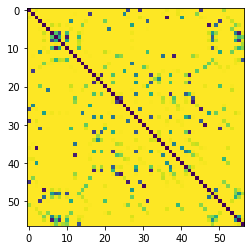

In [44]:
crop_object2 = crop_matrices(objects2)
print(crop_object2[615][0][0].shape)
plt.imshow(crop_object2[615][0][0])

import math

#we are now going to use only the images with dimension greater that 50 as CNN will work on them primarily
#creating a copy of the cropped data set
crop3 = np.copy(crop_object2).item()

#for all the objects present in the crop_object object
for key in tqdm(crop3.keys()):
    #obtain the shape of the object
    shape = crop3[key][0][0].shape[0]
    if shape < 11:
        for passband in np.unique(merged.passband):
            #how much we will increase the border
            increaseBorder = abs(shape-11)/2
            #this much amount will increase
            crop3[key][0][passband] = cv2.copyMakeBorder(src = crop3[key][0][passband],
                                                             top = math.ceil(increaseBorder), 
                                                             left = math.ceil(increaseBorder),
                                                             bottom = round(increaseBorder),
                                                             right = round(increaseBorder),
                                                             borderType = cv2.BORDER_REFLECT)
    elif shape>11 and shape < 25:
        for passband in np.unique(merged.passband):
            crop3[key][0][passband] = crop3[key][0][passband][:-(shape-11), :-(shape-11)]
            
    
    elif shape >= 50 and shape < 57:
        for passband in np.unique(merged.passband):
            increaseBorder57 = abs(shape-57)/2
            crop3[key][0][passband] = cv2.copyMakeBorder(src = crop3[key][0][passband],
                                                             top = math.ceil(increaseBorder57), 
                                                             left = math.ceil(increaseBorder57),
                                                             bottom = round(increaseBorder57),
                                                             right = round(increaseBorder57),
                                                             borderType = cv2.BORDER_REFLECT)
    else:
        continue
        
objects = list(crop3.keys())
input_images2 = list()
labels2 = list()
for key in tqdm(objects):
    if crop3[key][0][0].shape[0] == 57:
        img = np.stack((crop3[key][0][0],
                        crop3[key][0][1],
                        crop3[key][0][2],
                        crop3[key][0][3],
                        crop3[key][0][4]), axis = -1)  
                                           
        input_images2.append(np.expand_dims(img, axis = 0))
        labels2.append(crop3[key][1])                                                        
input_images2 = np.vstack(input_images2)     
input_images2.shape

train_fraction = 0.8
#Contructing the labels required for the classification tasks
encoder = LabelBinarizer()
y2 = encoder.fit_transform(labels)
x2 = input_images

#the test, train split

train_tensors2, test_tensors2, train_targets2, test_targets2 =\
    train_test_split(x2, y2, train_size = train_fraction, random_state = 42)

val_size2 = int(0.5*len(test_tensors2))

val_tensors2 = test_tensors2[:val_size2]
val_targets2 = test_targets2[:val_size2]
test_tensors2 = test_tensors2[val_size2:]
test_targets2 = test_targets2[val_size2:]

In [45]:
#Attempt 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = (None, None,5)))
model.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 2)) 

model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 2)) 

model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(GlobalMaxPooling2D()) 

model.add(Dense(256, activation = 'linear'))
model.add(Dense(128, activation = 'linear'))
model.add(Dense(14, activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 100
model.fit(train_tensors2, train_targets2, 
          validation_data=(val_tensors2, val_targets2),
          epochs=epochs, batch_size=80, verbose=1)

Epoch 1/100
17/17 [==============================] - 1s 60ms/step - loss: 2.3946 - accuracy: 0.2380 - val_loss: 2.1059 - val_accuracy: 0.4634
Epoch 2/100
17/17 [==============================] - 1s 51ms/step - loss: 1.9521 - accuracy: 0.4099 - val_loss: 1.9989 - val_accuracy: 0.4634
Epoch 3/100
17/17 [==============================] - 1s 51ms/step - loss: 1.9000 - accuracy: 0.4099 - val_loss: 1.9472 - val_accuracy: 0.4634
Epoch 4/100
17/17 [==============================] - 1s 51ms/step - loss: 1.8908 - accuracy: 0.4099 - val_loss: 1.8832 - val_accuracy: 0.4634
Epoch 5/100
17/17 [==============================] - 1s 52ms/step - loss: 1.8893 - accuracy: 0.4099 - val_loss: 1.8683 - val_accuracy: 0.4634
Epoch 6/100
17/17 [==============================] - 1s 51ms/step - loss: 1.8929 - accuracy: 0.4099 - val_loss: 1.8657 - val_accuracy: 0.4634
Epoch 7/100
17/17 [==============================] - 1s 51ms/step - loss: 1.8958 - accuracy: 0.4099 - val_loss: 1.8834 - val_accuracy: 0.4634
Epoch 

In [46]:

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = (None, None,5)))
model.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 2)) 

model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 2)) 

model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(GlobalMaxPooling2D()) 

model.add(Dense(256, activation = 'linear'))
model.add(Dense(128, activity_regularizer='l1', activation = 'relu'))
model.add(Dense(14, activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 100
model.fit(train_tensors2, train_targets2, 
          validation_data=(val_tensors2, val_targets2),
          epochs=epochs, batch_size=80, verbose=1)

Epoch 1/100
17/17 [==============================] - 1s 60ms/step - loss: 2.5301 - accuracy: 0.3878 - val_loss: 2.4537 - val_accuracy: 0.4634
Epoch 2/100
17/17 [==============================] - 1s 51ms/step - loss: 2.1652 - accuracy: 0.4099 - val_loss: 2.2503 - val_accuracy: 0.4634
Epoch 3/100
17/17 [==============================] - 1s 51ms/step - loss: 2.0838 - accuracy: 0.4099 - val_loss: 2.1632 - val_accuracy: 0.4634
Epoch 4/100
17/17 [==============================] - 1s 51ms/step - loss: 2.0384 - accuracy: 0.4099 - val_loss: 2.0621 - val_accuracy: 0.4634
Epoch 5/100
17/17 [==============================] - 1s 52ms/step - loss: 2.0039 - accuracy: 0.4099 - val_loss: 2.0158 - val_accuracy: 0.4634
Epoch 6/100
17/17 [==============================] - 1s 52ms/step - loss: 1.9854 - accuracy: 0.4099 - val_loss: 2.0714 - val_accuracy: 0.4634
Epoch 7/100
17/17 [==============================] - 1s 51ms/step - loss: 1.9629 - accuracy: 0.4099 - val_loss: 2.1698 - val_accuracy: 0.4634
Epoch 

In [48]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = (None, None,5)))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 2)) 


model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 2)) 


model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(GlobalMaxPooling2D()) 

model.add(Dense(256, activation = 'linear'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, kernel_regularizer='l1', activation = 'relu'))
model.add(Dense(14, activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 100
model.fit(train_tensors2, train_targets2, 
          validation_data=(val_tensors2, val_targets2),
          epochs=epochs, batch_size=80, verbose=1)

Epoch 1/100
17/17 [==============================] - 1s 36ms/step - loss: 20.1442 - accuracy: 0.3878 - val_loss: 17.8467 - val_accuracy: 0.4634
Epoch 2/100
17/17 [==============================] - 0s 28ms/step - loss: 15.6576 - accuracy: 0.4099 - val_loss: 13.6685 - val_accuracy: 0.4634
Epoch 3/100
17/17 [==============================] - 0s 28ms/step - loss: 11.8619 - accuracy: 0.4099 - val_loss: 10.2569 - val_accuracy: 0.4634
Epoch 4/100
17/17 [==============================] - 0s 27ms/step - loss: 8.7067 - accuracy: 0.4099 - val_loss: 7.4976 - val_accuracy: 0.4634
Epoch 5/100
17/17 [==============================] - 0s 28ms/step - loss: 6.1957 - accuracy: 0.4099 - val_loss: 5.1634 - val_accuracy: 0.4634
Epoch 6/100
17/17 [==============================] - 0s 27ms/step - loss: 4.3365 - accuracy: 0.4099 - val_loss: 3.7355 - val_accuracy: 0.4634
Epoch 7/100
17/17 [==============================] - 0s 28ms/step - loss: 3.1185 - accuracy: 0.4099 - val_loss: 2.9480 - val_accuracy: 0.4634


In [56]:
#Applying new metric to the best model yet

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = (None, None,5)))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 2)) 


model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 2)) 


model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(GlobalMaxPooling2D()) 

model.add(Dense(256, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, kernel_regularizer='l1', activation = 'relu'))
model.add(Dense(14, activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.PrecisionAtRecall(recall=0.6)])

epochs = 100
model.fit(train_tensors2, train_targets2, 
          validation_data=(val_tensors2, val_targets2),
          epochs=epochs, batch_size=80, verbose=1)

Epoch 1/100
17/17 [==============================] - 1s 40ms/step - loss: 20.2949 - precision_at_recall_5: 0.2220 - val_loss: 17.8368 - val_precision_at_recall_5: 0.2988
Epoch 2/100
17/17 [==============================] - 0s 28ms/step - loss: 15.8093 - precision_at_recall_5: 0.2565 - val_loss: 13.9208 - val_precision_at_recall_5: 0.2988
Epoch 3/100
17/17 [==============================] - 0s 29ms/step - loss: 12.0367 - precision_at_recall_5: 0.2596 - val_loss: 10.3976 - val_precision_at_recall_5: 0.3158
Epoch 4/100
17/17 [==============================] - 0s 29ms/step - loss: 8.8560 - precision_at_recall_5: 0.2700 - val_loss: 7.6583 - val_precision_at_recall_5: 0.3049
Epoch 5/100
17/17 [==============================] - 0s 29ms/step - loss: 6.3457 - precision_at_recall_5: 0.2536 - val_loss: 5.4169 - val_precision_at_recall_5: 0.3358
Epoch 6/100
17/17 [==============================] - 0s 29ms/step - loss: 4.4495 - precision_at_recall_5: 0.2517 - val_loss: 3.8312 - val_precision_at_rec

17/17 [==============================] - 0s 29ms/step - loss: 0.8960 - precision_at_recall_5: 0.8080 - val_loss: 1.3416 - val_precision_at_recall_5: 0.6012
Epoch 98/100
17/17 [==============================] - 0s 29ms/step - loss: 0.9041 - precision_at_recall_5: 0.8041 - val_loss: 1.3631 - val_precision_at_recall_5: 0.6712
Epoch 99/100
17/17 [==============================] - 0s 28ms/step - loss: 0.8764 - precision_at_recall_5: 0.8037 - val_loss: 1.2874 - val_precision_at_recall_5: 0.6577
Epoch 100/100
17/17 [==============================] - 0s 29ms/step - loss: 0.8186 - precision_at_recall_5: 0.8460 - val_loss: 1.2108 - val_precision_at_recall_5: 0.7717
